In [41]:
import os, sys
sys.path.insert(0, '/Users/kv/workspace/kv-capstone/NBAwinshare/source')

from source import seasonalregressor
from source import data_wrangle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import pickle
from sklearn.metrics import mean_squared_error
import importlib
from source.helper_functions import weighted_mean_multi_col_weight as wm2

%matplotlib inline

## Read in Data

Read in NBA player data into various dataframes, and join them in the "fullstats" dataframe.

In [42]:
advanced = data_wrangle.read_all_advanced('./data/advanced')
pergame  = data_wrangle.read_all_pergame('./data/per_game')
seasonal = data_wrangle.clean_and_join_seasonal_dataframe(advanced, pergame)
demographic = data_wrangle.read_demographic_data('./data/player_data.csv')
fullstats = data_wrangle.add_years_in_league(seasonal, demographic)


The test and train sets are split up by player name. For consistency, I saved the test and train set names in a pickle object so that I would not have to re-run a train/test split in every new notebook iteration 

In [43]:
with open('train_test.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    trainnames, testnames = pickle.load(f)
    

Get the actual Win-Shares for players in the test set for scoring purposes.

In [3]:
actuals = data_wrangle.get_actuals_for_years_5_thru_9(fullstats, testnames)

## Use the Seasonal Regressor to Fit and Predict Future Performance

Based on my initial grid-search, I am using only a small subset of fields to train the random forest predictors in the Seasonal Regressor object:

OBPM - Offensive Box-plus-minus

FGA  - Field goal attempts per game (2's and 3's)

DRB  - Defensive rebounds per game

2P   - Two pointers attempted per game

FG   - Field goals made per game

In [9]:
cols_to_train_from_feature_search = ['OBPM', 'FGA', 'DRB', '2P', 'FG']

My grid-search aslo indicated that the best averaging method for seasons 1-4 was to use weights of season-number * Games played in that season, which the wm2 function provides.

In [15]:
sr = seasonalregressor.SeasonalRegressor(columns_to_train=cols_to_train_from_feature_search, function=wm2)

Create the train-test split dataframes, utilizing the Seasonal Regressor method.

In [16]:
fulltrain, fulltest = sr.create_train_test_split(fullstats, trainnames, testnames)

Fit the Seasonal Regressor to the training data.

In [18]:
sr = sr.fit(fulltrain)

Predict the win-shares of the test set.  The *predict* method returns a dictionary of results, with the player name as the key and a list of predictions as the values.  

The *unpack_prediction_dictionary* method converts that dictionary to a single list of predictions.

In [27]:
pred_dict = sr.predict(fulltest)
predictions = sr.unpack_prediction_dictionary(pred_dict)

Calculate the mean-squared-error for the test set.

In [40]:
score = mean_squared_error(actuals, predictions)
print("Mean-squared error: ", score)
print("Average error:      ", score**.5)

Mean-squared error:  7.131040264516131
Average error:       2.670400768520735


The average error indicates that the model is off 2.67 win-shares per player per year.

## The LBJ Effect
LeBron is an outlier, and just so happens to be in the train set.  LBJ is arguably the GOAT.  How much does his presence in the training set affect the scoring on the predict method?

Let's filter LeBron out of the training set and test again.

In [33]:
LBJ_less_train = fulltrain[fulltrain['Player'] != 'LeBron James']

In [37]:
sr_no_LBJ = seasonalregressor.SeasonalRegressor(columns_to_train=cols_to_train_from_feature_search, function=wm2)
sr_no_LBJ = sr_no_LBJ.fit(LBJ_less_train)
pred_dict_noLBJ = sr_no_LBJ.predict(fulltest)
predictions_noLBJ = sr_no_LBJ.unpack_prediction_dictionary(pred_dict_noLBJ)

In [45]:
score_no_lbj = mean_squared_error(actuals, predictions_noLBJ)
print("Mean-squared error: ", score_no_lbj)
print("Average error:      ", score_no_lbj**.5)
print("Percent difference: ", abs(score_no_lbj-score)/score*100)

Mean-squared error:  7.0723757548387125
Average error:       2.659393869820473
Percent difference:  0.8226641205397733


Based on these training features, LBJ doesn't seem to significantly affect the predictions.  Because the underlying predictors are Random Forests, that's the behavior I would expect--as Random Forests are not as sensitive to outliers as other regression models.

## Individual Player Performance Predictions

Let's plot some individual player predictions.  First, let's see who is in the test-set.

In [50]:
sorted(testnames)

['Andrea Bargnani',
 'Andris Biedrins',
 'Antawn Jamison',
 'Brian Cook',
 'Brook Lopez',
 'Bruce Bowen',
 'Cuttino Mobley',
 'Dwyane Wade',
 'Earl Boykins',
 'Erick Strickland',
 'Francisco Garcia',
 'Goran Dragic',
 'Jake Voskuhl',
 'Jared Jeffries',
 'Jason Williams',
 'Kirk Hinrich',
 'Kobe Bryant',
 'Kris Humphries',
 'Mike Dunleavy',
 'Raef LaFrentz',
 'Rasual Butler',
 'Robin Lopez',
 'Sasha Pavlovic',
 'Shannon Brown',
 'Shawn Marion',
 'Spencer Hawes',
 'Stephon Marbury',
 'Steve Nash',
 'Tony Battie',
 'Tyronn Lue',
 'Vitaly Potapenko']

### Hall-of-Famers
Let's start with the future (or current) Hall-of-Famers / MVP Winners.

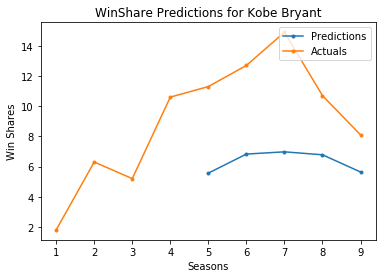

In [52]:
sr.plot_player_arc(fullstats, 'Kobe Bryant', pred_dict)

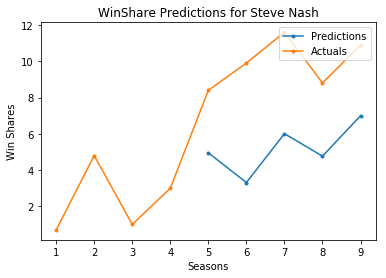

In [53]:
sr.plot_player_arc(fullstats, 'Steve Nash', pred_dict)

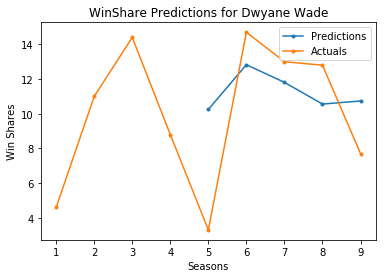

In [55]:
sr.plot_player_arc(fullstats, 'Dwyane Wade', pred_dict)

D-Wade had a really odd 5th year in terms of actual Win-Shares, but he quickly returned to form in year 6.

### Some Good-But-Not-All-World Players

Let's look at guys that are All-Star caliber

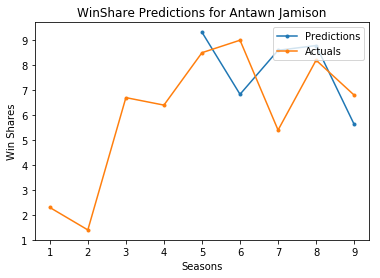

In [58]:
sr.plot_player_arc(fullstats, 'Antawn Jamison', pred_dict)

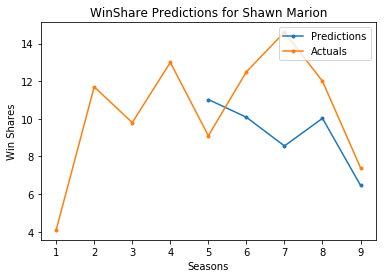

In [59]:
sr.plot_player_arc(fullstats, 'Shawn Marion', pred_dict)

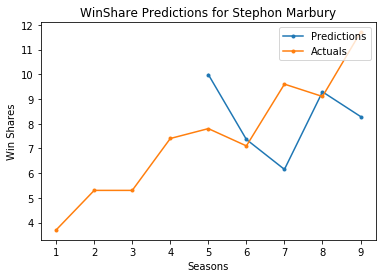

In [60]:
sr.plot_player_arc(fullstats, 'Stephon Marbury', pred_dict)

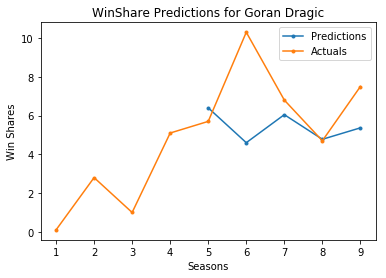

In [67]:
sr.plot_player_arc(fullstats, 'Goran Dragic', pred_dict)

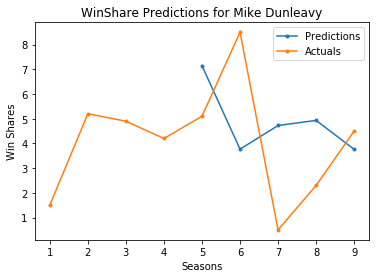

In [62]:
sr.plot_player_arc(fullstats, 'Mike Dunleavy', pred_dict)

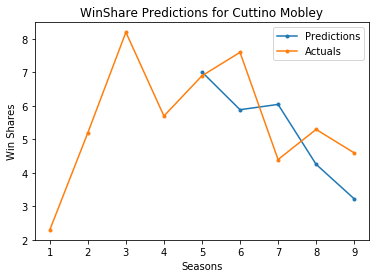

In [63]:
sr.plot_player_arc(fullstats, 'Cuttino Mobley', pred_dict)

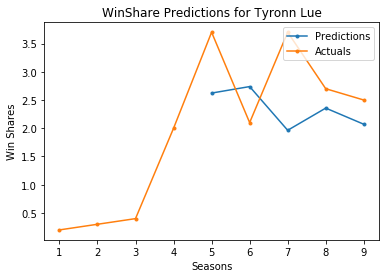

In [66]:
sr.plot_player_arc(fullstats, 'Tyronn Lue', pred_dict)

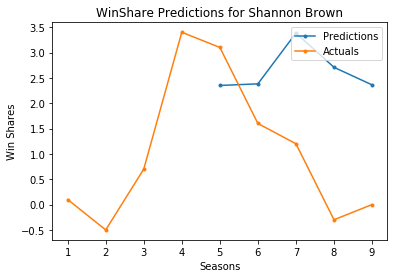

In [65]:
sr.plot_player_arc(fullstats, 'Shannon Brown', pred_dict)

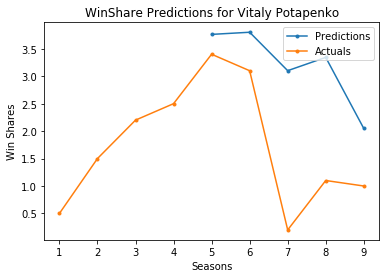

In [68]:
sr.plot_player_arc(fullstats, 'Vitaly Potapenko', pred_dict)